## Import Sentiel 2 data

In [ ]:
import pandas as pd
import openpyxl
import os
import glob
from pathlib import Path


In [ ]:
file_path = Path("Tabular_Sem1-A15129") / "Sentinel2_meanVI_harmonic_anonymized.csv"

# Convert to an absolute path (optional)
file_path = file_path.resolve()
df_sentinel2 = pd.read_csv(file_path, header= 0,encoding='utf-8')
# remove unnamed column
df_sentinel2 = df_sentinel2.iloc[:,1:]
df_sentinel2.head()


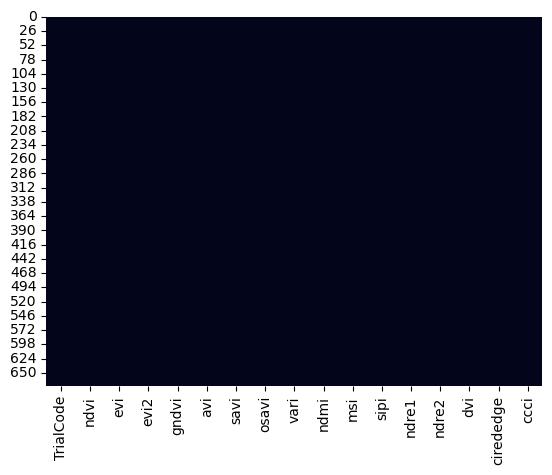

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df_sentinel2.isna(), cbar=False)
plt.show()

In [ ]:
df_sentinel2.shape

In [ ]:
df_sentinel2['TrialCode'].unique()

### EDA for Sentinel 2 Data

In [ ]:
df_sentinel2.duplicated().sum()

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.DataFrame(df_sentinel2.isnull().sum(), columns=['Number of missing values']).transpose()

## Distribution of Spectral Indeices

In [ ]:
import matplotlib.pyplot as plt

df_sentinel2.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

### Handle missing values

In [ ]:
pd.set_option('display.max_columns', None)



df_sentinel2 = df_sentinel2.drop('gci', axis=1)

#print(df_sentinel.shape)
rows_with_missing = df_sentinel2.isnull().any(axis=1).sum()
print(f"Rows with missing values: {rows_with_missing}")

# no missing values found

In [ ]:
df_sentinel2.columns

In [ ]:
missing_counts = df_sentinel2.isna().sum(axis=1)

total_columns = df_sentinel2.shape[1]
threshold = total_columns * 0.5
  # Adjust threshold as needed (e.g., 2)

# Filter rows with many missing values
#rows_with_many_missing = df_sentinel2[missing_counts > threshold]
#remove rows with many missing values
df_sentinel2 = df_sentinel2[missing_counts <= threshold]
df_sentinel2.shape

In [ ]:
pd.DataFrame(df_sentinel2.isnull().sum(), columns=['Number of missing values']).transpose()

## Median Imputation

In [ ]:
cols_to_impute = ['B2',
       'B3', 'B4', 'B5', 'B8', 'B8A', 'B11', 'ndvi', 'evi', 'evi2', 'gndvi',
       'avi', 'savi', 'osavi', 'vari', 'ndmi', 'msi', 'sipi', 'ndre1', 'ndre2',
       'dvi', 'cirededge', 'ccci']
df_sentinel2[cols_to_impute] = df_sentinel2[cols_to_impute].fillna(df_sentinel2[cols_to_impute].median())
pd.DataFrame(df_sentinel2.isnull().sum(), columns=['Number of missing values']).transpose()


#used median method to impute missing values because data is skewed

In [ ]:
pd.DataFrame(df_sentinel2.isnull().sum(), columns=['Number of missing values']).transpose()
df_sentinel2.head()

In [ ]:
df_sentinel2.shape

In [ ]:
df_sentinel2['TrialCode'].unique()

In [ ]:
import re

def extract_trials(code):
    # Extract all occurrences of trial_X where X is anything but empty
    trials = re.findall(r'trial_[^_]+', code)
    return trials

# Apply and explode
df_sentinel2['TrialCode'] = df_sentinel2['TrialCode'].apply(extract_trials)
df_sentinel2 = df_sentinel2.explode('TrialCode')


In [ ]:
df_sentinel2['TrialCode'].unique()

## Join with the Centralised dataFrame called (df_centralised)

In [ ]:
file_path = Path("intermediate_tables") / "parquet_files" / "processed_weather_and_crop_data.parquet"
df_centralised = pd.read_parquet(file_path, engine='pyarrow')

In [ ]:
cols_to_keep = ['ndvi', 'evi', 'evi2', 'gndvi',
       'avi', 'savi', 'osavi', 'vari', 'ndmi', 'msi', 'sipi', 'ndre1', 'ndre2',
       'dvi', 'cirededge', 'ccci']
df_sentinel2 = df_sentinel2.groupby('TrialCode')[cols_to_keep].mean().reset_index()
df_centralised = pd.merge(df_centralised, df_sentinel2, on='TrialCode', how='left')

In [ ]:
df_centralised.shape

In [ ]:
pd.DataFrame(df_centralised.isnull().sum(), columns=['Number of missing values'])

### Only keep rows with sentinel 2 data

In [ ]:
df_centralised = df_centralised.dropna()

In [ ]:
pd.DataFrame(df_centralised.isnull().sum(), columns=['Number of missing values'])

In [ ]:
file_path = Path("intermediate_tables") / "parquet_files" / "processed_weather_crop_sentinel2_data.parquet"

file_path = file_path.resolve()
df_centralised.to_parquet(file_path, index=False, engine='pyarrow')

In [ ]:
file_path = Path("intermediate_tables") / "csv_files" / "processed_weather_crop_sentinel2_data.csv"

file_path = file_path.resolve()
df_centralised.to_csv(file_path, index=False)